# 社会学データの分析例

このノートブックでは社会学データの典型的分析例を紹介する。典型的な社会学データは離散的な順序変数を含むことが多いが、lingamパッケージに実装されている大部分の因果探索アルゴリズムは、離散的な順序変数を分析することができない。しかし、因果探索を実行する前にいくつかの工夫を加えることで、離散的な順序変数を分析することが可能となる。

このノートブックでは、目的となるシンク変数が離散変数、

以降では、離散的な順序変数を含むデータの分析方法を説明する。

## 準備

### ライブラリのインポート

このノートブックで使用するライブラリをインポートする。

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

import matplotlib.pyplot as plt

from lingam.utils import make_dot

### 設定

乱数の種を固定するための設定を行う。

In [2]:
np.random.seed(0)

## テストデータ

### 隣接行列

In [3]:
m = np.array([
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 1.043, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 1.727, 0.537, 0.000, 0.000, 0.000, 0.000, 0.000],
    [1.041, 0.911, 0.000, 0.427, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 1.960, 0.691, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.883, 1.385, 0.000],
])

names = [f"x{i}" for i in range(len(m))]
m = pd.DataFrame(m, columns=names, index=names)

m

,x0,x1,x2,x3,x4,x5,x6,x7
x0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x3,0.000,1.043,0.000,0.000,0.000,0.000,0.000,0.0
x4,0.000,1.727,0.537,0.000,0.000,0.000,0.000,0.0
x5,1.041,0.911,0.000,0.427,0.000,0.000,0.000,0.0
x6,0.000,0.000,0.000,1.960,0.691,0.000,0.000,0.0
x7,0.000,0.000,0.000,0.000,0.000,0.883,1.385,0.0


この隣接行列を因果グラフとして描画した図は次の通り:

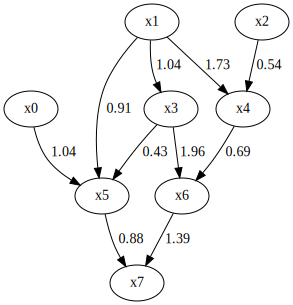

In [4]:
make_dot(m, lower_limit=0)

### データの生成

隣接行列に従ってデータを生成する。x1 と x7 を 0 または 1 の値を持つ離散的な順序変数とする。

In [5]:
# 設定
n_sample = 1000
discrete_indices = [0, 7]

# テストデータの初期化
X = np.zeros((len(m), n_sample))

# 因果順序に従ってデータを生成
for i in range(len(m)):
    if i not in discrete_indices:
        X[i] = m.iloc[i] @ X + np.random.uniform(-1.732, 1.732, size=n_sample)
    else:
        X[i] = (expit(m.iloc[i] @ X) >= np.random.uniform(0, 1, size=n_sample)).astype(int)
X = pd.DataFrame(X.T, columns=names)

# 離散変数をintに、連続変数をfloatに変換
dtypes = {}
for i, name in enumerate(names):
    dtypes[name] = int if i in discrete_indices else float
X = X.astype(dtypes)

データのヒストグラムは次の通り

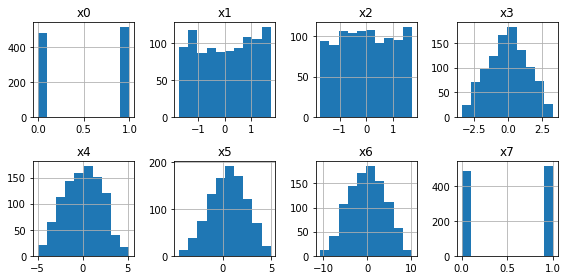

In [6]:
X.hist(layout=(2, 4), figsize=(8, 4))
plt.tight_layout()
plt.show()

## 分析の実行

作成したテストデータXから隣接行列を推定する。

### 変数を3つの集合に分割

